# Аналитика в Яндекс.Афише #

Проанализируем данные и поможем маркетологам оптимизировать маркетинговые затраты.

### Загрузка данных и подготовка их к анализу

In [1]:
#сначала выведем таблицы исходных данных
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

visits = pd.read_csv('/datasets/visits_log.csv')
visits.head(10)

,Uid,Device,End Ts,Source Id,Start Ts
0,16879256277535980062,touch,20.12.2017 17:38,4,20.12.2017 17:20
1,104060357244891740,desktop,19.02.2018 17:21,2,19.02.2018 16:53
2,7459035603376831527,touch,01.07.2017 1:54,5,01.07.2017 1:54
3,16174680259334210214,desktop,20.05.2018 11:23,9,20.05.2018 10:59
4,9969694820036681168,desktop,27.12.2017 14:06,3,27.12.2017 14:06
5,16007536194108375387,desktop,03.09.2017 21:36,5,03.09.2017 21:35
6,6661610529277171451,desktop,30.01.2018 12:09,1,30.01.2018 11:13
7,11423865690854540312,touch,05.11.2017 15:15,3,05.11.2017 15:14
8,2987360259350925644,desktop,19.07.2017 10:44,3,19.07.2017 10:41
9,1289240080042562063,desktop,08.11.2017 13:43,5,08.11.2017 13:42


In [2]:
orders = pd.read_csv('/datasets/orders_log.csv')
orders.head(10)

,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450
5,2017-06-01 08:43:00,0.18,10402394430196413321
6,2017-06-01 08:54:00,1.83,12464626743129688638
7,2017-06-01 09:22:00,1.22,3644482766749211722
8,2017-06-01 09:22:00,3.30,17542070709969841479
9,2017-06-01 09:23:00,0.37,1074355127080856382


In [3]:
costs = pd.read_csv('/datasets/costs.csv')
costs.head(10)

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08
5,1,2017-06-06,40.39
6,1,2017-06-07,40.59
7,1,2017-06-08,56.63
8,1,2017-06-09,40.16
9,1,2017-06-10,43.24


Рассмотрим подробнее каждую таблицу.

In [4]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 358532 entries, 0 to 358531
Data columns (total 5 columns):
Uid          358532 non-null uint64
Device       358532 non-null object
End Ts       358532 non-null object
Source Id    358532 non-null int64
Start Ts     358532 non-null object
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


Видим, что в таблице visits нет пропусков, но столбики End Ts и Start Ts имеют тип object, нужно будет перевести в формат даты.

In [5]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


Видим, что и в таблице orders нет пропусков, также поменяем тип данных столбика Buy Ts на дату

In [6]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


Также видим, что пропусков нет,но необходимо поменять формат столбца dt.

In [7]:
#в названии столбиков таблиц есть пробелы, уберем их, а также исключим заглавные буквы
visits.columns = ['uid','device','session_end_ts','source_id','session_start_ts']
orders.columns = ['order_date','revenue','uid']
costs.columns = ['source_id','date_costs','costs']

In [8]:
#преобразуем столбики с датами
visits['session_start_ts'] = pd.to_datetime(visits['session_start_ts'], format="%d.%m.%Y %H:%M")
visits['session_end_ts'] = pd.to_datetime(visits['session_end_ts'], format="%d.%m.%Y %H:%M")
visits.head()

,uid,device,session_end_ts,source_id,session_start_ts
0,16879256277535980062,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00
1,104060357244891740,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00
2,7459035603376831527,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00
3,16174680259334210214,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00
4,9969694820036681168,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00


Чтобы посчитать дневное, недельное и месячное использование, выделим в отдельные столбцы день, неделю и месяц, а также полную дату

In [9]:
visits['session_week']  = visits['session_start_ts'].dt.week
visits['session_month'] = visits['session_start_ts'].dt.month
visits['session_year']  = visits['session_start_ts'].dt.year
visits['session_date'] = visits['session_start_ts'].dt.date
visits.head()

,uid,device,session_end_ts,source_id,session_start_ts,session_week,session_month,session_year,session_date
0,16879256277535980062,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,51,12,2017,2017-12-20
1,104060357244891740,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,8,2,2018,2018-02-19
2,7459035603376831527,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,26,7,2017,2017-07-01
3,16174680259334210214,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,20,5,2018,2018-05-20
4,9969694820036681168,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,52,12,2017,2017-12-27


Начнем подготовку отчетов для формулирования выводов

### Сколько людей пользуются в день, неделю, месяц?

Для того, чтобы ответить на данный вопрос, нам необходимо сгруппировать данные по уникальным пользователям, найти среднее и посчитать метрики.

In [10]:
dau = visits.groupby('session_date').agg({'uid': 'nunique'}).mean()
print('Количество уникальных пользователей в день:', int(dau), 'человек')

Количество уникальных пользователей в день: 907 человек


In [11]:
wau = visits.groupby(['session_year','session_week']).agg({'uid': 'nunique'}).mean()
print('Количество уникальных пользователей в неделю:', int(wau), 'человек')

Количество уникальных пользователей в неделю: 5716 человек


In [12]:
mau = visits.groupby(['session_year','session_month']).agg({'uid': 'nunique'}).mean()
print('Количество уникальных пользователей в месяц:', int(mau), 'человек')

Количество уникальных пользователей в месяц: 23228 человек


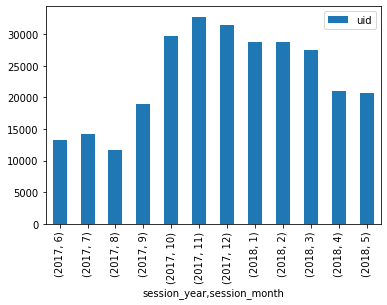

In [13]:
#визуализируем полученные данные
visits.groupby(['session_year','session_month']).agg({'uid': 'nunique'}).plot(kind='bar')
plt.show()

**Вывод:** Как мы видим, количество уникальных пользователей возрастает в осенние и зимние месяцы. В весенне-летний период,  их количество снижается. Это можно объяснить тем, что многие уезжают в отпуска, а также тем, что многие развлекательные заведения (например, театры) закрывают сезон и также уходят на каникулы. 

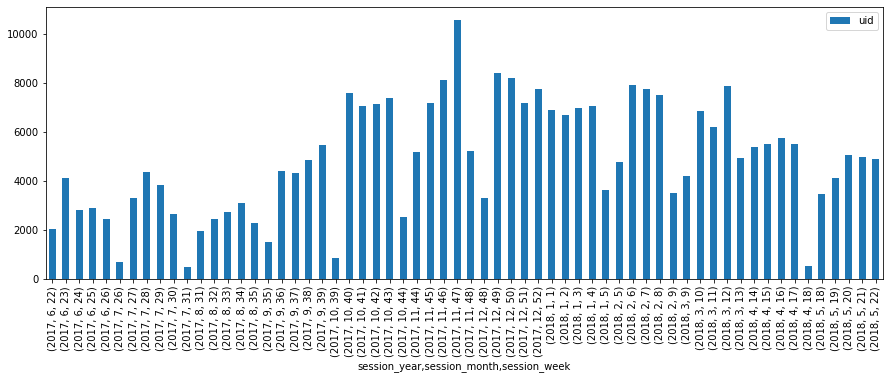

In [14]:
visits.groupby(['session_year','session_month','session_week']).agg({'uid': 'nunique'}).plot(kind='bar', figsize = (15,5))
plt.show()

**Вывод:** в распределении по неделям также видим похожую ситуацию: пики в осенне-зимний период и спад в весенне-летний период. резкие падения обусловлены количеством дней, относящимся к неделе, что значит то, что некорректно группировать сразу по неделе и месяцу, необходимо оставить номера недель и год.

### Сколько сессий в день?

In [15]:
#сгруппируем данные по месяцам и дням, найдем количество сессий и количество уникальных пользователей
sessions_per_user = visits.groupby(['session_month', 'session_date']).agg({'uid': ['count','nunique']})
sessions_per_user.columns = ['n_sessions', 'n_users']

In [16]:
#разделим число сессий на количество пользователей за период
sessions_per_user['sess_per_user'] = sessions_per_user['n_sessions'] / sessions_per_user['n_users']
sessions_per_user.head(10)

n_sessions  n_users  sess_per_user
session_month session_date                                    
1             2018-01-01          1062      992       1.070565
              2018-01-02          1351     1265       1.067984
              2018-01-03          1314     1219       1.077933
              2018-01-04          1367     1260       1.084921
              2018-01-05          1091     1006       1.084493
              2018-01-06           972      915       1.062295
              2018-01-07           882      831       1.061372
              2018-01-08           977      903       1.081949
              2018-01-09          1211     1128       1.073582
              2018-01-10          1235     1142       1.081436

In [17]:
#посмотрим на параметры ежедневных сессий за весь период
sessions_per_user['sess_per_user'].describe()

count    364.000000
mean       1.079590
std        0.020580
min        1.000000
25%        1.067951
50%        1.079198
75%        1.090710
max        1.209099
Name: sess_per_user, dtype: float64

**Вывод:** в среднем в день один пользователь проводит в приложении 1,079590 сессий. Получается, что в приложение не заходят регулярно, на это необходимо обратить внимание.

### Сколько длится одна сессия? 

In [18]:
#посчитаем среднюю продолжительность сессии или ASL
visits['session_duration_min'] = (visits['session_end_ts'] - visits['session_start_ts']).dt.seconds / 60
print('Средняя продолжительность сессии:', visits['session_duration_min'].mean(), 'мин')

Средняя продолжительность сессии: 10.750306806644874 мин


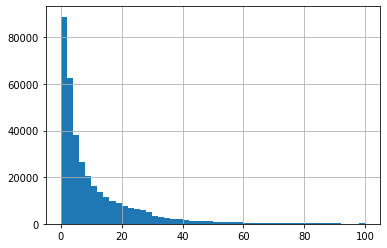

In [19]:
#посмотрим на распределение нашей выборки
visits['session_duration_min'].hist(bins = 50, range = (0,100))
plt.show()

Когда распределение близко к нормальному или нормальное — можно смотреть на среднюю или медиану. Наше — не из таких, рассчитаем моду:

In [20]:
print('Продолжительность сессии чаще всего равна:', visits['session_duration_min'].mode())

Продолжительность сессии чаще всего равна: 0    1.0
dtype: float64


**Вывод:** Средняя продолжительность сессии равна 1 минуте, сложно сказать, много это или мало, но главное, чтобы пользователи успевали сделать заказ. 

### Как часто люди возвращаются?

In [21]:
#Сгруппируем данные по столбцу 'uid' методом groupby(). Для каждого клиента получим месяц его первого заказа
first_visit_date = visits.groupby(['uid'])['session_start_ts'].min()
#заменим название столбика `session_month` на `first_session_month`
first_visit_date.name = 'first_visit_date'

In [22]:
#Методом join() объединим датафрейм visits и Series first_session_month по столбцу `uid`
visits = visits.join(first_visit_date, on='uid')
#укоротим дату до месяца
visits['first_visit_month'] = visits['first_visit_date'].astype('datetime64[M]')
visits['visit_month'] = visits['session_start_ts'].astype('datetime64[M]')

In [23]:
#Теперь для каждой строки датафрейма можно рассчитать lifetime пользователя в рамках когорты
visits['cohort_lifetime'] = (visits['visit_month'] - visits['first_visit_month'])

# еще сильнее укоротим дату и переведем в строковый формат
visits['first_visit_month'] = visits['first_visit_month'].dt.strftime('%Y-%m')
visits['visit_month'] = visits['visit_month'].dt.strftime('%Y-%m')

In [24]:
#получим целочисленное значение путем округления
try:
    visits['cohort_lifetime'] = visits['cohort_lifetime'] / np.timedelta64(1,'M')    
except:
    print('Что-то пошло не так, не удается выполнить операцию!')
visits['cohort_lifetime'] = visits['cohort_lifetime'].round().astype('int')
visits.head()

,uid,device,session_end_ts,source_id,session_start_ts,session_week,session_month,session_year,session_date,session_duration_min,first_visit_date,first_visit_month,visit_month,cohort_lifetime
0,16879256277535980062,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,51,12,2017,2017-12-20,18.0,2017-12-20 17:20:00,2017-12,2017-12,0
1,104060357244891740,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,8,2,2018,2018-02-19,28.0,2018-02-19 16:53:00,2018-02,2018-02,0
2,7459035603376831527,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,26,7,2017,2017-07-01,0.0,2017-07-01 01:54:00,2017-07,2017-07,0
3,16174680259334210214,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,20,5,2018,2018-05-20,24.0,2018-03-09 20:05:00,2018-03,2018-05,2
4,9969694820036681168,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,52,12,2017,2017-12-27,0.0,2017-12-27 14:06:00,2017-12,2017-12,0


In [25]:
#Посчитаем для каждой когорты количество активных пользователей на определённый «месяц жизни»:
cohorts = visits.groupby(['first_visit_month','cohort_lifetime']).agg({'uid':'nunique'}).reset_index()

In [26]:
#Найдём исходное количество пользователей в когорте
inital_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_visit_month','uid']]
inital_users_count

,first_visit_month,uid
0,2017-06,13259
12,2017-07,13140
23,2017-08,10181
33,2017-09,16704
42,2017-10,25977
50,2017-11,27248
57,2017-12,25268
63,2018-01,22624
68,2018-02,22197
72,2018-03,20589


In [27]:
#Переименуем столбец `uid` в `cohort_users`
inital_users_count = inital_users_count.rename(columns={'uid':'cohort_users'})

In [28]:
#Объединим данные по когортам с исходным количеством пользователей в когорте:
cohorts = cohorts.merge(inital_users_count,on='first_visit_month')

In [29]:
#рассчитаем Retention Rate
cohorts['retention'] = cohorts['uid']/cohorts['cohort_users']

In [30]:
#Построим сводную таблицу и создадим тепловую карту
retention_pivot = cohorts.pivot_table(index='first_visit_month',columns='cohort_lifetime',values='retention',aggfunc='sum')

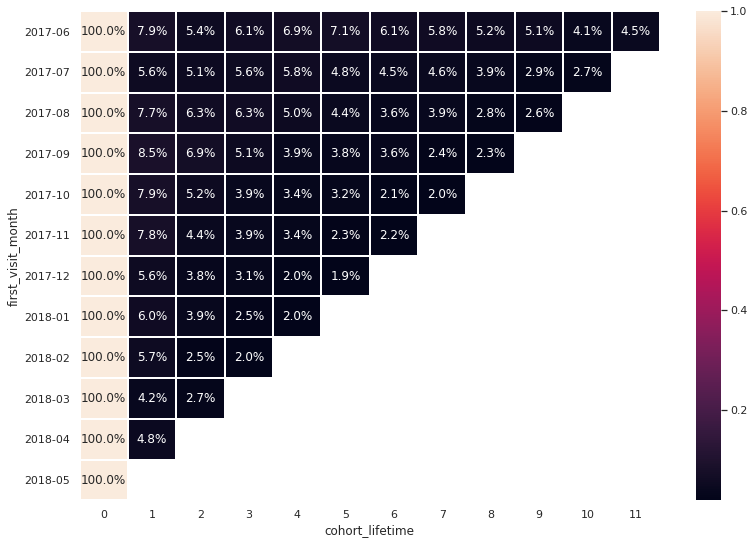

In [31]:
import seaborn as sns

sns.set(style='white')
plt.figure(figsize=(13, 9))

sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=1)
plt.show()

**Вывод:** Retention Rate с течением времени меняется незначительно, общий тренд - снижение показателя по всем когортам.

### Когда люди начинают покупать?

Чтобы понять, когда покупатели начинают покупать, нужно найти разницу между их первым посещением сайта и первой покупкой, а для этого определим дату первой покупки, а затем соединим таблицы visits и orders

In [32]:
#Сгруппируем данные по столбцу 'uid' методом groupby(). Для каждого клиента получим дату его первого заказа — ['order_date'].min():
first_order_date_by_customers = orders.groupby(['uid'])['order_date'].min()
#заменим название столбика `order_date` на `first_order_date`
first_order_date_by_customers.name = 'first_order_date'

In [33]:
#Методом join() объединим датафрейм orders и Series first_order_date_by_customers по столбцу `uid`
orders_2 = orders.join(first_order_date_by_customers, on='uid')
visits_orders = orders_2.join(first_visit_date, on = 'uid')
visits_orders = visits_orders.loc[:, ['uid','first_order_date','first_visit_date']]

In [34]:
# посмотрим, есть ли у нас дубликаты
visits_orders.duplicated().sum()
# удалим дубли
visits_orders = visits_orders.drop_duplicates().reset_index(drop=True)

In [35]:
#преобразуем формат в дату
visits_orders['first_order_date'] = visits_orders['first_order_date'].astype('datetime64[ns]')

In [36]:
#наконец посчитаем разницу между первым посещением сайта и первой покупкой пользователей
visits_orders['start_buing'] = (visits_orders['first_order_date'] - visits_orders['first_visit_date'])
#посмотрим, что получилось
visits_orders.head(10)

,uid,first_order_date,first_visit_date,start_buing
0,10329302124590727494,2017-06-01 00:10:00,2017-06-01 00:09:00,00:01:00
1,11627257723692907447,2017-06-01 00:25:00,2017-06-01 00:14:00,00:11:00
2,17903680561304213844,2017-06-01 00:27:00,2017-06-01 00:25:00,00:02:00
3,16109239769442553005,2017-06-01 00:29:00,2017-06-01 00:14:00,00:15:00
4,14200605875248379450,2017-06-01 07:58:00,2017-06-01 07:31:00,00:27:00
5,10402394430196413321,2017-06-01 08:43:00,2017-06-01 08:43:00,00:00:00
6,12464626743129688638,2017-06-01 08:54:00,2017-06-01 08:51:00,00:03:00
7,3644482766749211722,2017-06-01 09:22:00,2017-06-01 18:34:00,-1 days +14:48:00
8,17542070709969841479,2017-06-01 09:22:00,2017-06-01 09:18:00,00:04:00
9,1074355127080856382,2017-06-01 09:23:00,2017-06-01 09:21:00,00:02:00


In [37]:
#видим, что у нас есть отрицательные значения: когда заказ сделан раньше, чем первый визит, сделаем срез и уберем такие значения
visits_orders = visits_orders.query('first_visit_date < first_order_date')
visits_orders.head(10)

,uid,first_order_date,first_visit_date,start_buing
0,10329302124590727494,2017-06-01 00:10:00,2017-06-01 00:09:00,00:01:00
1,11627257723692907447,2017-06-01 00:25:00,2017-06-01 00:14:00,00:11:00
2,17903680561304213844,2017-06-01 00:27:00,2017-06-01 00:25:00,00:02:00
3,16109239769442553005,2017-06-01 00:29:00,2017-06-01 00:14:00,00:15:00
4,14200605875248379450,2017-06-01 07:58:00,2017-06-01 07:31:00,00:27:00
6,12464626743129688638,2017-06-01 08:54:00,2017-06-01 08:51:00,00:03:00
8,17542070709969841479,2017-06-01 09:22:00,2017-06-01 09:18:00,00:04:00
9,1074355127080856382,2017-06-01 09:23:00,2017-06-01 09:21:00,00:02:00
10,12888070354554424008,2017-06-01 09:58:00,2017-06-01 09:48:00,00:10:00
11,4409266971612110231,2017-06-01 10:27:00,2017-06-01 09:55:00,00:32:00


In [38]:
#переведем значения в минуты
visits_orders['start_buing'] = (visits_orders['start_buing'].dt.seconds / 60).astype(int)
visits_orders.head(10)

,uid,first_order_date,first_visit_date,start_buing
0,10329302124590727494,2017-06-01 00:10:00,2017-06-01 00:09:00,1
1,11627257723692907447,2017-06-01 00:25:00,2017-06-01 00:14:00,11
2,17903680561304213844,2017-06-01 00:27:00,2017-06-01 00:25:00,2
3,16109239769442553005,2017-06-01 00:29:00,2017-06-01 00:14:00,15
4,14200605875248379450,2017-06-01 07:58:00,2017-06-01 07:31:00,27
6,12464626743129688638,2017-06-01 08:54:00,2017-06-01 08:51:00,3
8,17542070709969841479,2017-06-01 09:22:00,2017-06-01 09:18:00,4
9,1074355127080856382,2017-06-01 09:23:00,2017-06-01 09:21:00,2
10,12888070354554424008,2017-06-01 09:58:00,2017-06-01 09:48:00,10
11,4409266971612110231,2017-06-01 10:27:00,2017-06-01 09:55:00,32


In [39]:
#посмотрим описательные статистики 
visits_orders.describe()

,uid,start_buing
count,3.406800e+04,34068.000000
mean,9.209318e+18,267.119937
std,5.319484e+18,439.535198
min,3.135781e+14,0.000000
25%,4.615023e+18,5.000000
50%,9.239494e+18,20.000000
75%,1.382168e+19,310.000000
max,1.844617e+19,1439.000000


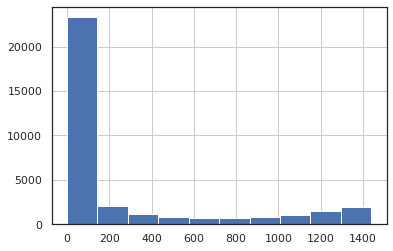

In [40]:
visits_orders['start_buing'].hist()

Когда распределение близко к нормальному или нормальное — можно смотреть на среднюю или медиану. Наше — не из таких, рассчитаем моду:

In [41]:
print('Чаще всего продолжительность времени заказа составляет:', visits_orders['start_buing'].mode())

Чаще всего продолжительность времени заказа составляет: 0    1
dtype: int64


**Вывод:** Чаще всего продолжительность времени заказа составляет 1 минуту, много это или мало, главное, чтобы клиенту хватило времени оформить заказ.

### Сколько раз покупают за период? 

In [42]:
#Сгруппируем данные по столбцу 'uid' методом groupby(). Для каждого клиента получим дату его первого заказа — ['order_date'].min():
first_order_date_by_customers = orders.groupby(['uid'])['order_date'].min()
#заменим название столбика `order_date` на `first_order_date`
first_order_date_by_customers.name = 'first_order_date'
#объединим датафрейм orders и Series first_order_date_by_customers по столбцу `uid`
orders_3 = orders.join(first_order_date_by_customers, on='uid')

In [43]:
#выделим из столбцов first_order_date и order_date месяцы. 
orders_3['first_order_month'] = orders_3['first_order_date'].astype('datetime64[M]')
orders_3['order_month'] = orders_3['order_date'].astype('datetime64[M]')
orders_3.head()

,order_date,revenue,uid,first_order_date,first_order_month,order_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,2017-06-01,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00,2017-06-01,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00,2017-06-01,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00,2017-06-01,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00,2017-06-01,2017-06-01


В качестве когорты выберем столбец first_order_month — месяц, в котором был сделан первый заказ. 
Сгруппируем данные по этому столбцу и оценим показатели каждой когорты.

In [44]:
cohort_grouped = orders_3.groupby('first_order_month').agg({'order_date':'nunique','uid':'nunique','revenue':'sum'})
cohort_grouped.head()

,order_date,uid,revenue
first_order_month,,,
2017-06-01,4322,2023,24031.69
2017-07-01,2797,1923,16127.92
2017-08-01,2133,1370,11606.26
2017-09-01,3730,2581,34676.32
2017-10-01,5573,4340,27603.45


Визуализируем полученные данные

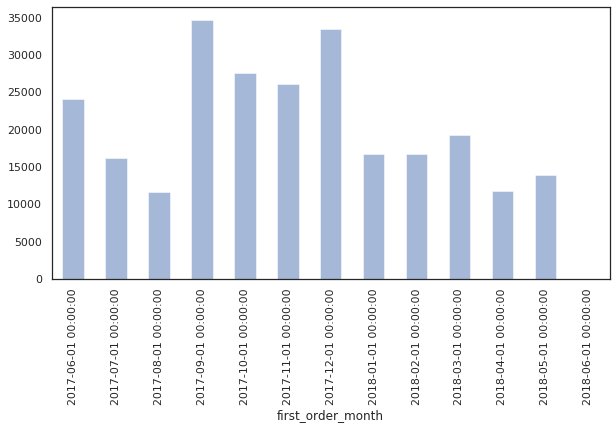

In [45]:
cohort_grouped['revenue'].plot(figsize = (10,5), alpha = 0.5, kind = 'bar')
plt.show()

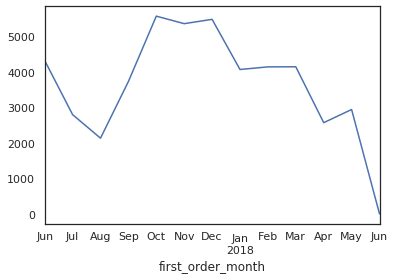

In [46]:
cohort_grouped['order_date'].plot()
plt.show()

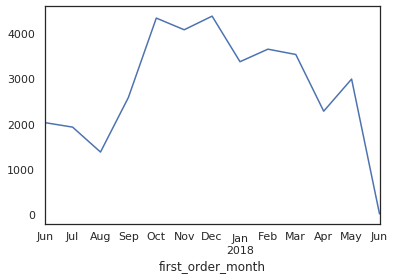

In [47]:
cohort_grouped['uid'].plot()
plt.show()

**Вывод:** Пиковые продажи приходятся на сентябрь - начало театрального периода и декабрь - время проведения новогодних мероприятий. А если посмотреть на количество заказов, то видно, что они растут, а выручка падает, значит средний чек по когортам снижается.

### Какой средний чек? 

In [48]:
check_order = sum(cohort_grouped['revenue'])/sum(cohort_grouped['order_date'])
print('Средний чек', check_order)

Средний чек 5.332399669973955


**Вывод:** Средний чек составил 5,332. 

### Сколько денег приносят? (LTV)

In [49]:
#выделим отдельно месяц из даты заказа
orders['order_month'] = orders['order_date'].astype('datetime64[M]')
costs_2 = costs
costs_2['month'] = costs['date_costs'].astype('datetime64[M]')

In [50]:
#найдем дату первого заказа
first_orders = orders.groupby('uid').agg({'order_month': 'min'}).reset_index()
first_orders.columns = ['uid', 'first_order_month']
print(first_orders.head())

                uid first_order_month
0   313578113262317        2018-01-01
1  1575281904278712        2017-06-01
2  2429014661409475        2017-10-01
3  2464366381792757        2018-01-01
4  2551852515556206        2017-11-01


In [51]:
#софрмируем когорты
cohort_sizes = first_orders.groupby('first_order_month')['uid'].nunique().reset_index()
cohort_sizes.columns = ['first_order_month', 'n_buyers']
cohort_sizes.head()

,first_order_month,n_buyers
0,2017-06-01,2023
1,2017-07-01,1923
2,2017-08-01,1370
3,2017-09-01,2581
4,2017-10-01,4340


In [52]:
orders_new = pd.merge(orders, first_orders, on='uid')

In [53]:
cohorts_orders = orders_new.groupby(['first_order_month', 'order_month'])['revenue'].sum().reset_index()
cohorts_orders.head()

,first_order_month,order_month,revenue
0,2017-06-01,2017-06-01,9557.49
1,2017-06-01,2017-07-01,981.82
2,2017-06-01,2017-08-01,885.34
3,2017-06-01,2017-09-01,1931.30
4,2017-06-01,2017-10-01,2068.58


In [54]:
cohorts = orders_new.groupby(['first_order_month','order_month']).agg({'revenue': 'sum'}).reset_index()
cohorts.head()

,first_order_month,order_month,revenue
0,2017-06-01,2017-06-01,9557.49
1,2017-06-01,2017-07-01,981.82
2,2017-06-01,2017-08-01,885.34
3,2017-06-01,2017-09-01,1931.30
4,2017-06-01,2017-10-01,2068.58


In [55]:
report = pd.merge(cohort_sizes, cohorts, on='first_order_month')
report.head()

,first_order_month,n_buyers,order_month,revenue
0,2017-06-01,2023,2017-06-01,9557.49
1,2017-06-01,2023,2017-07-01,981.82
2,2017-06-01,2023,2017-08-01,885.34
3,2017-06-01,2023,2017-09-01,1931.30
4,2017-06-01,2023,2017-10-01,2068.58


In [56]:
report['gp'] = report['revenue'] 
report['age'] = (report['order_month'] - report['first_order_month']) / np.timedelta64(1, 'M')
report['age'] = report['age'].round().astype('int')
report.head()

,first_order_month,n_buyers,order_month,revenue,gp,age
0,2017-06-01,2023,2017-06-01,9557.49,9557.49,0
1,2017-06-01,2023,2017-07-01,981.82,981.82,1
2,2017-06-01,2023,2017-08-01,885.34,885.34,2
3,2017-06-01,2023,2017-09-01,1931.30,1931.30,3
4,2017-06-01,2023,2017-10-01,2068.58,2068.58,4


In [57]:
report['ltv'] = report['gp'] / report['n_buyers']
result = report.pivot_table(index='first_order_month', columns='age', 
                                           values='ltv', aggfunc='sum').round(2)

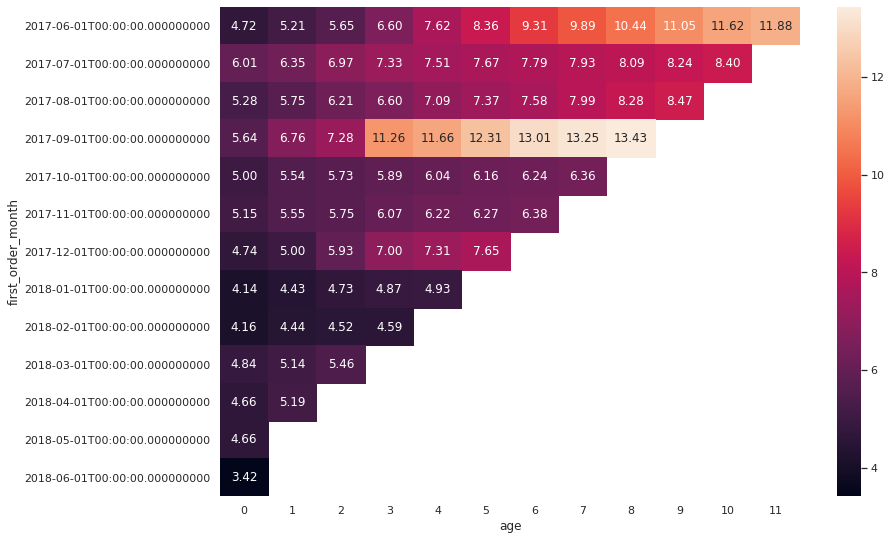

In [58]:
plt.figure(figsize=(13, 9))
sns.heatmap(result.cumsum(axis=1).round(2), annot=True, fmt='.2f')
plt.show()

**Вывод:** «Пожизненная» ценность клиента растет по всем когортам, но скорость роста разная, у июньской и сентябрьской - самая быстрая. 

### Сколько денег потратили? Всего / на каждый источник / по времени 

In [59]:
costs_2.head()

,source_id,date_costs,costs,month
0,1,2017-06-01,75.20,2017-06-01
1,1,2017-06-02,62.25,2017-06-01
2,1,2017-06-03,36.53,2017-06-01
3,1,2017-06-04,55.00,2017-06-01
4,1,2017-06-05,57.08,2017-06-01


In [60]:
orders_ltv = orders.set_index('uid')
orders_ltv['order_month'] = orders_ltv['order_date'].astype('datetime64[M]')
costs_2['date_costs'] = pd.to_datetime(costs_2['date_costs'])
costs_2 = costs_2.rename(columns = {'date_costs':'purchase_date'})
costs_2.head()

,source_id,purchase_date,costs,month
0,1,2017-06-01,75.20,2017-06-01
1,1,2017-06-02,62.25,2017-06-01
2,1,2017-06-03,36.53,2017-06-01
3,1,2017-06-04,55.00,2017-06-01
4,1,2017-06-05,57.08,2017-06-01


In [61]:
#сгруппируем уникальных пользователей
orders_uid = orders['uid'].unique()

In [62]:
#уберем ошибки
import warnings
warnings.filterwarnings('ignore')

In [63]:
# приведем в порядок дату 
costs_2['purchase_date'] = costs_2['purchase_date'].astype('datetime64[M]')
# сгруппируем по месяцу затрат наши источники прихода посетителей 
costs_grouped = costs_2.groupby(['purchase_date','source_id'])['costs'].agg({'costs':'sum'})
costs_grouped.head()

costs
purchase_date source_id         
2017-06-01    1          1125.61
              2          2427.38
              3          7731.65
              4          3514.80
              5          2616.12

In [64]:
# сделаем срез по уникальным пользователям
sourse_visits = visits[['uid', 'first_visit_date', 'source_id']].query('uid in @orders_uid')
# преобразуем дату
sourse_visits['first_visit_date'] = sourse_visits['first_visit_date'].astype('datetime64[M]')
#переименуем колонки
sourse_visits.columns = ['uid', 'purchase_date','source_id']
# сгруппируем по дате и источнику привлечения пользователей, сделавших заказ
sourse_visits = sourse_visits.groupby(['purchase_date','source_id'])['uid'].agg({'uid':'nunique'})
sourse_visits.join(costs_grouped)

uid     costs
purchase_date source_id                
2017-06-01    1           706   1125.61
              2           847   2427.38
              3          1387   7731.65
              4          1136   3514.80
              5           908   2616.12
              9           369    285.22
              10          182    314.22
2017-07-01    1           565   1072.88
              2           629   2333.11
              3          1021   7674.37
              4          1035   3529.73
              5           789   2998.14
              9           256    302.54
              10          106    329.82
2017-08-01    1           368    951.81
              2           381   1811.05
              3           681   6143.54
              4           682   3217.36
              5           605   2185.28
              7             1       NaN
              9           217    248.93
              10           77    232.57
2017-09-01    1           650   1502.01
              2           671   2985.66
              3          1286   9963.55
              4          1142   5192.26
              5          1038   3849.14
              9           311    415.62
              10          140    460.67
2017-10-01    1           911   2315.75
...                       ...       ...
2018-01-01    9           174    547.16
              10          133    614.35
2018-02-01    1           533   2204.48
              2           508   4474.34
              3          1115  14228.56
              4          1188   5711.96
              5           809   5071.31
              9           144    551.50
              10          153    480.88
2018-03-01    1           488   1893.09
              2           446   3943.14
              3           928  13080.85
              4          1063   5961.87
              5           639   4529.62
              9           182    480.29
              10          188    526.41
2018-04-01    1           303   1327.49
              2           298   2993.70
              3           576   9296.81
              4           669   4408.49
              5           490   3501.15
              9            34    373.49
              10          114    388.25
2018-05-01    1           351   1467.61
              2           418   2689.44
              3           683   9411.42
              4           682   4214.21
              5           499   3669.56
              9            40    362.17
              10          115    409.86

[85 rows x 2 columns]

In [65]:
sourse_visits_total = sourse_visits.join(costs_grouped)

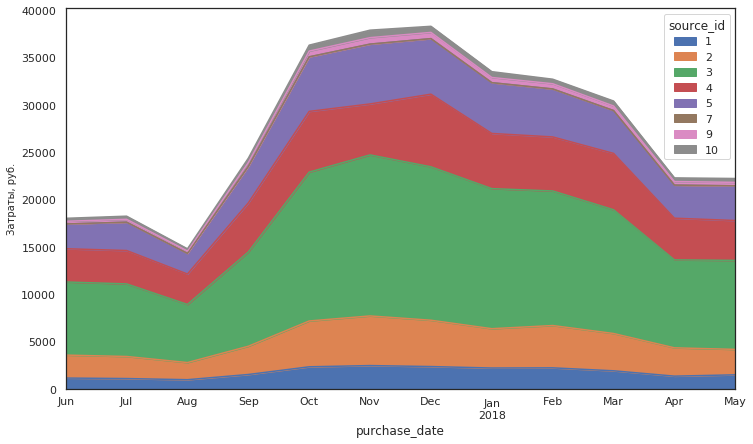

In [66]:
#Визуализируем данные по источникам привлечения
pivot_costs = sourse_visits_total.pivot_table(index = 'purchase_date',
                                              columns = 'source_id',
                                              values = 'costs',
                                             aggfunc = 'sum').plot.area(figsize= (12,7))
plt.ylabel('Затраты, руб.', fontsize=10) 
plt.show()

In [67]:
# посмотрим на общую сумму затрат по периодам
sourse_costs_total = sourse_visits_total.groupby(['purchase_date']).agg({'costs':'sum'})
sourse_costs_total

,costs
purchase_date,
2017-06-01,18015.00
2017-07-01,18240.59
2017-08-01,14790.54
2017-09-01,24368.91
2017-10-01,36322.88
2017-11-01,37907.88
2017-12-01,38315.35
2018-01-01,33518.52
2018-02-01,32723.03


In [68]:
# посмотрим на общую сумму затрат по каждому из источников привлечения пользователей
sourse_costs_total_1 = sourse_visits_total.groupby(['source_id']).agg({'costs':'sum'})
sourse_costs_total_1

,costs
source_id,
1,20833.27
2,42806.04
3,141321.63
4,61073.60
5,51757.10
7,0.00
9,5517.49
10,5822.49


**Вывод:** построенные графики подтверждают тезис о том, что максимальные суммы затрат приходятся на осенний период, когда возрастает интерес к различным мероприятиям. источник 3 значительно отличается по затратам от других источников. При этом на 6, 7 и 8 источники вообще не финансируются. Начиная с августа 2017 затраты растут по всем источникам сразу.

### Сколько стоило привлечение одного покупателя из каждого источника? 

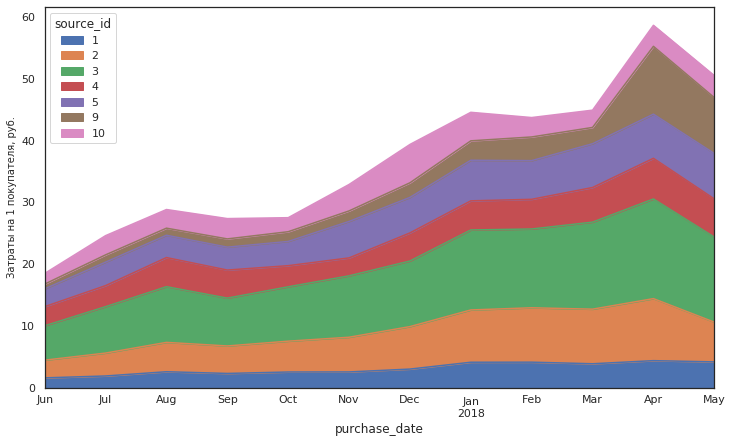

In [69]:
sourse_visits_total['costs_uid'] = sourse_visits_total['costs'] / sourse_visits_total['uid']

sourse_visits_total_per_user = sourse_visits_total.pivot_table(index = 'purchase_date',columns ='source_id', values = 'costs_uid', aggfunc = 'median')
sourse_visits_total_per_user.plot.area(figsize= (12,7))
plt.ylabel('Затраты на 1 покупателя, руб.', fontsize=10) 
plt.show()

**Вывод:**  Видим, что с течением времени наши затраты на привлечение пользователей растут, при этом 3 источник привлечения самый дорогой для компании, а самые дешевые - 1 и 9.

### На сколько окупились расходы? (ROI)

Вернемся к нашему LTV и посмотрим, как и когда у нас окупаются когорты. Поскольку не все пользователи успели "дожить" до 11 месяца: например, по пользователям мая 2018 у нас есть только 2 месяца данных, а по пользователям июня 2017 - 11 месяцев, поэтому ограничим по времени наши выборки датой и временем 2017-12-31 23:59:59

In [70]:
costs_3 = costs
costs_3.head()

,source_id,date_costs,costs,month
0,1,2017-06-01,75.20,2017-06-01
1,1,2017-06-02,62.25,2017-06-01
2,1,2017-06-03,36.53,2017-06-01
3,1,2017-06-04,55.00,2017-06-01
4,1,2017-06-05,57.08,2017-06-01


In [71]:
costs_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 4 columns):
source_id     2542 non-null int64
date_costs    2542 non-null datetime64[ns]
costs         2542 non-null float64
month         2542 non-null datetime64[ns]
dtypes: datetime64[ns](2), float64(1), int64(1)
memory usage: 79.5 KB


In [72]:
costs_3['date_costs'] = pd.to_datetime(costs_3['date_costs'])
costs_3=costs_3.rename(columns = {'date_costs':'purchase_date'})

In [73]:
#подготовим данные
orders_ltv_2 = orders.set_index('uid')
orders_ltv_2['order_month'] = orders_ltv_2['order_date'].astype('datetime64[M]')
costs_3['purchase_date'] = pd.to_datetime(costs_3['purchase_date'])
#costs=costs.rename(columns = {'date_costs':'purchase_date'})
orders_ltv_2.head()

,order_date,revenue,order_month
uid,,,
10329302124590727494,2017-06-01 00:10:00,17.00,2017-06-01
11627257723692907447,2017-06-01 00:25:00,0.55,2017-06-01
17903680561304213844,2017-06-01 00:27:00,0.37,2017-06-01
16109239769442553005,2017-06-01 00:29:00,0.55,2017-06-01
14200605875248379450,2017-06-01 07:58:00,0.37,2017-06-01


In [74]:
#строим профили пользователей
users = visits.groupby('uid').agg({'session_start_ts':'min'}).rename(columns= {'session_start_ts': 'purchase_dt'})
users = visits.set_index('uid').join(users)
users= users.query('session_start_ts == purchase_dt')[['purchase_dt', 'device','source_id']]
users['purchase_date'] = users['purchase_dt'].dt.date
users['purchase_month'] = users['purchase_dt'].astype('datetime64[M]')
users= users.reset_index().set_index(['source_id','purchase_date']).join(costs_3.set_index(['source_id','purchase_date']), how = 'left')
users.head(3)

uid         purchase_dt   device  \
source_id purchase_date                                                      
1         2017-06-01      9714640286797951674 2017-06-01 21:45:00  desktop   
          2017-06-01      9909415513333099415 2017-06-01 13:24:00    touch   
          2017-06-01     10329302124590727494 2017-06-01 00:09:00  desktop   

                        purchase_month  costs      month  
source_id purchase_date                                   
1         2017-06-01        2017-06-01   75.2 2017-06-01  
          2017-06-01        2017-06-01   75.2 2017-06-01  
          2017-06-01        2017-06-01   75.2 2017-06-01

In [75]:
#добавляем стоимость приобретения индивидуального пользователя
cac = (users.groupby(['source_id','purchase_date'])
       .agg({'device':'count', 'costs':'max'}).rename(columns = {'device':'users'}))
cac['purchase_cost'] = cac['costs'] / cac['users']

users = users.join(cac[['purchase_cost']], how = 'left').reset_index()

users = users.set_index('uid')[['purchase_dt','purchase_date','purchase_month','source_id','device','purchase_cost']]

users.head(3)

,purchase_dt,purchase_date,purchase_month,source_id,device,purchase_cost
uid,,,,,,
9714640286797951674,2017-06-01 21:45:00,2017-06-01,2017-06-01,1,desktop,1.671111
9909415513333099415,2017-06-01 13:24:00,2017-06-01,2017-06-01,1,touch,1.671111
10329302124590727494,2017-06-01 00:09:00,2017-06-01,2017-06-01,1,desktop,1.671111


In [76]:
#сделаем срез по времени посещения 
users_2 = users.query('purchase_dt <= "2017-12-31 23:59:59"')
#users_2 = users_2.loc[:,['purchase_dt','device','source_id','purchase_date','purchase_month']]
users_2.head()

,purchase_dt,purchase_date,purchase_month,source_id,device,purchase_cost
uid,,,,,,
9714640286797951674,2017-06-01 21:45:00,2017-06-01,2017-06-01,1,desktop,1.671111
9909415513333099415,2017-06-01 13:24:00,2017-06-01,2017-06-01,1,touch,1.671111
10329302124590727494,2017-06-01 00:09:00,2017-06-01,2017-06-01,1,desktop,1.671111
10349500346348845391,2017-06-01 19:55:00,2017-06-01,2017-06-01,1,desktop,1.671111
10534330097262531592,2017-06-01 22:55:00,2017-06-01,2017-06-01,1,desktop,1.671111


In [77]:
#сделаем срез по времени заказа 
orders_ltv_2 = orders_ltv.query('order_date <= "2017-12-31 23:59:59"')
orders_ltv_2.info()

<class 'pandas.core.frame.DataFrame'>
UInt64Index: 27467 entries, 10329302124590727494 to 6908394736870396778
Data columns (total 3 columns):
order_date     27467 non-null object
revenue        27467 non-null float64
order_month    27467 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 858.3+ KB


In [78]:
#рассчитаем когорты
cohorts_source = (users_2.groupby('source_id')
                .agg({'device':'count', 'purchase_cost':'sum'})
                .rename(columns = {'device':'cohort_size'}))
cohorts_source['cac'] = cohorts_source['purchase_cost'] / cohorts_source['cohort_size']
cohorts_source

,cohort_size,purchase_cost,cac
source_id,,,
1,5451,11754.42,2.156379
2,10326,24547.68,2.377269
3,38914,80495.21,2.068541
4,39672,34944.28,0.880830
5,29933,29613.94,0.989341
6,2,0.00,0.000000
7,22,0.00,0.000000
9,4123,3175.23,0.770126
10,3334,3401.37,1.020207


In [79]:
orders_ltv_2.head()

,order_date,revenue,order_month
uid,,,
10329302124590727494,2017-06-01 00:10:00,17.00,2017-06-01
11627257723692907447,2017-06-01 00:25:00,0.55,2017-06-01
17903680561304213844,2017-06-01 00:27:00,0.37,2017-06-01
16109239769442553005,2017-06-01 00:29:00,0.55,2017-06-01
14200605875248379450,2017-06-01 07:58:00,0.37,2017-06-01


In [80]:
#считаем ltv в месячных когортах с разбивкой по источникам
ltv_source = orders_ltv_2.join(users_2, how ='left')[['source_id','purchase_month','order_month','revenue']]
ltv_source['age_month'] =((ltv_source['order_month'] - ltv_source['purchase_month']) / np.timedelta64(1,'M')).round().astype('int')
ltv_source = ltv_source.groupby(['source_id','age_month']).agg({'revenue':'sum'})
ltv_source = pd.pivot_table(ltv_source, index = 'source_id', columns ='age_month', values = 'revenue', aggfunc= 'mean')
ltv_source =ltv_source.cumsum(axis = 1)
ltv_source = cohorts_source[['cohort_size']].join(ltv_source)

#делим все ячейки в рядах на соответствующую когорту
ltv_source= ltv_source.div(ltv_source['cohort_size'], axis = 0).drop(columns= ['cohort_size'])
ltv_source.head()

,0,1,2,3,4,5,6
source_id,,,,,,,
1,1.719097,2.085028,2.337953,2.700659,2.845595,2.951446,3.039837
2,1.065427,1.472274,1.570900,1.707488,1.842431,1.908681,1.980380
3,0.619551,0.701117,0.739939,0.765590,0.783300,0.796174,0.801480
4,0.558486,0.624683,0.651445,0.677905,0.702924,0.735912,0.768453
5,0.650705,0.726516,0.778237,1.128267,1.173317,1.188052,1.210725


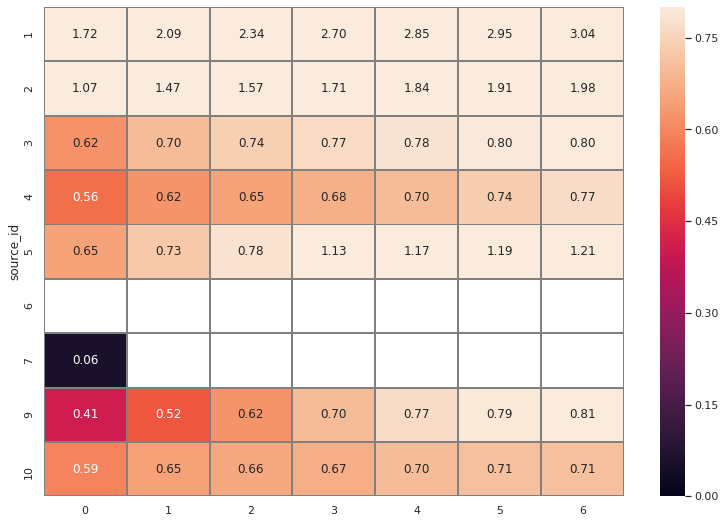

In [81]:
ltv_source.fillna('')
plt.figure(figsize = (13,9))
sns.heatmap(ltv_source, annot= True, fmt = '.2f', linewidths = 1, linecolor = 'gray', vmin = 0, vmax = 0.8)

**Вывод:** видим, что за 6 месяцев по всем источникам растет LTV. Несмотря на то, что на 3 источник привлечения приходится наибольшая часть финансирования, LTV по нему не растет быстрыми темпами. Самыми быстро окупаемыми источниками привлечения клиентов являются 1, 2 и 5, а 3 источник привлечения, имея самые высокие вложения, не окупается к 6 месяцу.

### Общие выводы:
1. В первую очередь маркетологам стоит обратить внимание на явную сезонность продукта: продумать акции на весенне-летний период (возможно раннее бронирование). 
2. C течением времени все сложнее привлекать посетителей по каждому источнику привлечения. Особое внимание стоит уделить 3 источнику, он имеет самые высокие затраты, и самое большое количество пользователей, совершающих заказ, а также посмотреть, что с 6,7 и 8 источниками и почему они не работают
3. Коэффициент удержания пользователей, имеющий отрицательный тренд, говорит о необходимости введения системы лояльности, маркетологам необходимо продумать способы возвращения клиентов, например, бонусные накопительные карты, кэшбэк и т.д.
4. Пожизненная» ценность клиента растет по всем когортам, но скорость роста разная, у первой и четвертой когорты ценность растет больше всего. Маркетологам стоит более подробно взглянуть на целевую аудиторию каждой когорты и попробовать разработать индивидуальные предложения.